### Exercise 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

---
### Large Dataset Generation
Generate a large set `(X, y)` of input-output examples as ground-truth population for two purposes: 

1. **Risk and variance computation:** Since `(X, y)` is the ground-truth, we can use it to compute the true risk $R(f)$ of a classifier $f$ and the variance $\mathbb{V}[\ell]$, where $\ell$ is the binary random variable with 

$$
\ell(x, y) = \begin{cases}
1 &:& f(x) \neq y\\
0 &:& \text{otherwise}
\end{cases}
$$

2. **Sampling:** Sample training and test sets from `(X, y)`.

In [2]:
# size of population
N = int(1e6)

centers = ((1, 1), (-1, 1), (-1, -1), (1, -1))
X, y = make_blobs(N, centers=centers, cluster_std=.5)
y[y==2], y[y==3] = 0, 1

In [ ]:
plt.points(centers)

---
### Auxiliary Functions

In [4]:
def sample(n, rs=None):
    '''Samples a training set of size n from the population (X, y).

    Parameter:
      n   size of training set
      rs  random state 
    '''
    X_tr, _, y_tr, _ = train_test_split(X, y, train_size=n, random_state=rs)
    return X_tr, y_tr


def init(f, n=100):
    ''' Initialize an experiment. 

    Parameters:
    f   classifier
    n   size of training set

    Return:
    f   trained classifier
    R   risk R(f) over ground-truth data
    V   estimated variance of 1{f(x)\neq y}
    '''

    # fit classifier
    X_train, y_train = sample(n, rs=13)
    f.fit(X_train, y_train)

    # true risk R(f) 
    errors = f.predict(X) != y
    R = np.mean(errors)

    # variance of 1{f(x)\neq y}
    V = np.var(errors)
    
    return f, R, V


def test_n(f, R, V, n, t=0.05, n_runs=100, verbose=True):
    ''' 
    This function repeats the following experiment n_runs times:

        1. sample a test set of size n from (X, y)
        2. compute the empirical risk Rn(f) on the test set
        3. compute the deviations |Rn(f) - R(f)|
    
    Count how often |Rn(f) - R(f)| >= t occurs and compute the fraction over all n_runs trials to approximate 

        P(|Rn(f) - R(f)| >= t). 
    
    Print the estimated probability and Chebyshev's bound if verbose is True. 

    Return the estimated probability and bound.

    Parameters:
    f        classifier
    R        risk R(f) over ground-truth data
    V        estimated variance of 1{f(x)\neq y}
    n        size of test set
    t        error tolerance in |Rn(f) - R(f)| >= t
    n_runs   number of trials
    verbose  print results if True 

    Return:
    prob    estimated probability P(|Rn(f) - R(f)| >= t)
    bound   estimated Chebyshev bound
    '''

    # Chebyshev's bound
    bound = V/(n*t*t)

    # estimate P(|Rn(f) - R(f)| >= t)
    n_deviations = 0
    for _ in range(n_runs):
        X_test, y_test = sample(n)
        Rn = 1. - f.score(X_test, y_test)
        if np.abs(Rn -  R) >= t:
            n_deviations += 1
    prob = n_deviations / n_runs
    
    if verbose:
        print(f'n            : {n:d}')
        print(f'R(f)         : {R:.2f}')
        print(f'Var(xi)      : {V:.2f}')
        print(f'# deviations : {n_deviations}')
        print(f'Chebyshev    : {bound:.2f}')
        print(f'P(|Rn(f)-R(f)| >= t) = {prob:.2f}', f' <= {bound:.2f}')

    return prob, bound

    
def test(f, R, V, t=0.05, n_runs=100):
    '''Call function test_n for varying sizes n.

    Return the sizes, probabilities, and bounds. The sizes n are hard coded. For each n, the estimated probability P(|Rn(f) - R(f)| >= t) and Chebyshev bound are returned by the function test_n. 
    
    Parameter:
    f       classifier
    R       risk R(f) over ground-truth data
    V       estimated variance of 1{f(x)\neq y}
    t       error tolerance
    n_runs  number of trials (for test_n)

    Return:
    size    array of sizes n
    p       array of estimated probabilities P(|Rn(f) - R(f)| >= t) 
    b       array of Chebyshev bounds
    '''
    
    size = [25, 50, 75, 100, 250, 500, 750, 1000, 1500]
    p = np.zeros(len(size))
    b = np.zeros(len(size))
    for i, n in enumerate(size):
        p[i], b[i] = test_n(f, R, V, n, t, n_runs, False)
    return size, p, b


def plot(size, p, b):
    '''Plots the probability of deviations and the Chebyshev bounds as a function of sample size.
    
    Parameter:
    size    array of sizes n
    p       array of estimated probabilities P(|Rn(f) - R(f)| >= t) 
    b       array of estimated Chebyshev bounds
    '''
    
    plt.plot(size, p, label='P(|Rn(f)-R(f)|>t)')
    plt.plot(size, b, label='bound')
    plt.ylim((-0.05, 1))
    plt.legend()
    plt.show()

---
### Logistic Regression


**Note:** The classifier f obtained by ERM on a training set is just an arbitrary choice. We could also randomly select a function from the underlying hypothesis space to conduct the experiment.

n            : 40
R(f)         : 0.38
Var(xi)      : 0.24
# deviations : 60
Chebyshev    : 2.37
P(|Rn(f)-R(f)| >= t) = 0.60  <= 2.37


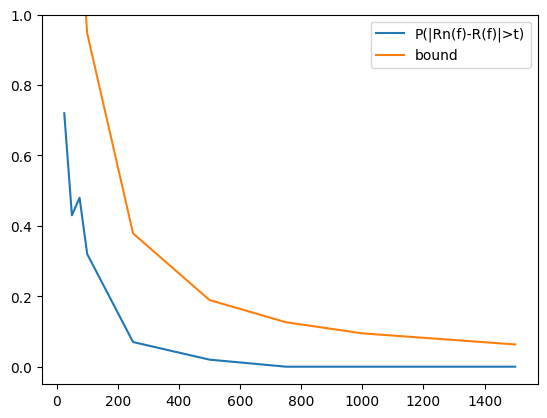

In [5]:
f = LogisticRegression(penalty='none')
f, R, V = init(f)
test_n(f, R, V, n=40)
size, prob, bound = test(f, R, V)
plot(size, prob, bound)

---
### MLP

In [ ]:
f = MLPClassifier(hidden_layer_sizes=(50, 250, 50), max_iter=1000)
f, R, V = init(f)
test_n(f, R, V, n=40)
size, prob, bound = test(f, R, V)
plot(size, prob, bound)

n            : 40
R(f)         : 0.07
Var(xi)      : 0.06
# deviations : 18
Chebyshev    : 0.61
P(|Rn(f)-R(f)| >= t) = 0.18  <= 0.61
